### Notebook to genereate cross sections from TC output binned according to a 2D variable.

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
4/23/22

In [1]:
# NOTE: Using copied tracking from CTL for NCRF tests

from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import subprocess
import sys
from thermo_functions import theta_virtual, relh, theta_equiv
from mask_tc_track import mask_tc_track

#### Main settings

In [2]:
# Index variable (2D; independent var)
ivar_select = 'pw'
# options (requiring 2D info): pw, rain, lwacre
# options (requiring 3D info): vmf

# Fill variable (3D; dependent var)
fillvar_select = 'lwcrf'
# options: avor, lwcrf, tprm, dbz, rh

# Contour variable (3D; dependent var)
contvar_select = 'w'

# Mask out all points except [stratiform/nonrain/etc], or switch off
istrat=-1 #2 # 0-non-raining, 1-conv, 2-strat, 3-other/anvil, (-1 for off)
# istrat=2

# Number of sample time steps
nt=6#24#6

#### Additional settings and directories

In [3]:
storm = 'haiyan'
# storm = 'maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'

# Time selection
hr_tag = str(np.char.zfill(str(nt), 2))

# Tests to read and compare
# tests = ['crfon','ncrf']
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

# Members
nmem = 1#10 # number of ensemble members (1-5 have NCRF)
# nmem = 5
# nmem = 1
enstag = str(nmem)
# Starting member to read
memb0=1

# Shift starting-read time step for CRFON comparison
t0_test=0
if tests[0] == 'crfon':
    t0_test=24
    memb0=5 # for CRFFON test

# TC tracking
ptrack='600' # tracking pressure level
var_track = 'rvor' # variable
rmax = 8 # radius (deg) limit for masking around TC center

nums=np.arange(memb0,nmem+memb0,1); nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

# Strat/Conv index subset
if istrat == -1:
    fig_extra=''
    strattag=''
else:
    if istrat == 0:
        strattag='Nonrain'
    elif istrat == 1:
        strattag='Conv'
    elif istrat == 2:
        strattag='Strat'
    elif istrat == 3:
        strattag='Anv'
    fig_extra='_'+strattag.lower()

In [4]:
nums=np.arange(memb0,nmem+memb0,1); nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

datdir2 = 'post/d02/'

##### Get dimensions

datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
datdir3d = datdir #+'v2/'
varfil_main = Dataset(datdir3d+'T.nc')
nz = varfil_main.dimensions['level'].size
# lat = varfil_main.variables['XLAT'][:][0] # deg
# lon = varfil_main.variables['XLONG'][:][0] # deg
nx1 = varfil_main.dimensions['lat'].size
nx2 = varfil_main.dimensions['lon'].size
pres = varfil_main.variables['pres'][:] # hPa
dp = (pres[1]-pres[0])*1e2 # Pa
varfil_main.close()

process = subprocess.Popen(['ls '+main+storm+'/'+memb_all[0]+'/'+tests[0]+'/wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
varfil_main.close()

#### NetCDF variable read functions

In [5]:
def var_read_3d(datdir,varname,t0,t1):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,:,:,:]
    varfil_main.close()
    return var
def var_read_2d(datdir,varname,t0,t1):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,:,:,:]
    varfil_main.close()
    return var

In [6]:
# For MSE variance terms

def read_mse(datdir,t0,t1):
    varfil_main = Dataset(datdir+'mse.nc')
    mse = varfil_main.variables['mse_int'][t0:t1,:,:] # J/m2
    varfil_main.close()
    return mse

def read_lwnet(datdir,t0,t1):
    lw_t = var_read_2d(datdir,'LWUPT',t0,t1) - var_read_2d(datdir,'LWDNT',t0,t1) # W/m2
    lw_b = var_read_2d(datdir,'LWUPB',t0,t1) - var_read_2d(datdir,'LWDNB',t0,t1) # W/m2
    lwnet = lw_b - lw_t
    return lwnet

def read_lwnetc(datdir,t0,t1):
    lw_t = var_read_2d(datdir,'LWUPTC',t0,t1) - var_read_2d(datdir,'LWDNTC',t0,t1) # W/m2
    lw_b = var_read_2d(datdir,'LWUPBC',t0,t1) - var_read_2d(datdir,'LWDNBC',t0,t1) # W/m2
    lwnetc = lw_b - lw_t
    return lwnetc

#### Main loops and compositing

In [7]:
# Main read loops for 3D (dependent) variables

# Arrays to save variables
ntest=2
var_all = np.ma.zeros((ntest,nmem,nt,nz,nx1,nx2))
cvar_all = np.ma.zeros((ntest,nmem,nt,nz,nx1,nx2))
strat_all = np.ma.zeros((ntest,nmem,nt,nx1,nx2))
mse_all = np.ma.zeros((ntest,nmem,nt,nx1,nx2))
mselw_all = np.ma.zeros((ntest,nmem,nt,nx1,nx2))
lwacre_all = np.ma.zeros((ntest,nmem,nt,nx1,nx2))

for ktest in range(ntest):

    test_str=tests[ktest]

    # This has been tested for corresponding time steps:
    #   t0=37,1 are the first divergent time steps in CTL,NCRF
    #   t0=25,1 are the first divergent time steps in NCRF,CRFON
    if test_str == 'ctl':
        if tests[1] == 'ncrf36h':
            t0=36
        elif tests[1] == 'ncrf48h':
            t0=48
    elif test_str == 'ncrf36h':
        t0=t0_test
    elif test_str == 'ncrf48h':
        t0=t0_test
    elif test_str == 'crfon':
        t0=0

    t0+=1 # add one time step since NCRF(t=0) = CTL
    t1 = t0+nt

    print('Running test: ',test_str)

    # Loop over ensemble members

    for imemb in range(nmem):
    
        print('Running imemb: ',memb_all[imemb])
    
        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
        datdir3d = datdir #+'v2/'
        print(datdir)

        # Localize to TC track
        # NOTE: Using copied tracking from CTL for NCRF tests
        # track_file = datdir+'../../track_'+var_track+'_'+ptrack+'hPa.nc'
        trackfil_ex=''
        if 'crf' in test_str:
            trackfil_ex='_ctlcopy'
        track_file = datdir+'../../track_'+var_track+trackfil_ex+'_'+ptrack+'hPa.nc'


        # Required variables

        # Stratiform index
        # if istrat != -1:
        varname = 'strat'
        strat = var_read_2d(datdir,varname,t0,t1) # 0-non-raining, 1-conv, 2-strat, 3-other/anvil

        # MSE variance
        mse = read_mse(datdir,t0,t1) # J/m2
        lwnet = read_lwnet(datdir,t0,t1) # W/m2
        lwnetc = read_lwnetc(datdir,t0,t1) # W/m2
        lwacre = lwnet - lwnetc
        lwnet = np.squeeze(lwnet)


        # Line contour variable ("cvar")
        # Vertical motion
        if contvar_select == 'w':
            varname='W'
            cvar = var_read_3d(datdir3d,varname,t0,t1)*1e2 # m/s --> cm/s
            units_var2='cm/s'
            lcmin = -20; lcmax=20; lcint=2


        # Three-dimensional dependent variables ("var")

        # Radar Reflectivity
        if fillvar_select == 'dbz':
            varname = fillvar_select
            var = var_read_3d(datdir3d,varname,t0,t1)
        # Radiation
        elif fillvar_select == 'lwcrf':
            varname = 'RTHRATLW'
            var = var_read_3d(datdir3d,varname,t0,t1) * 3600.*24 # K/s --> K/d
            varname = 'RTHRATLWC'
            var -= var_read_3d(datdir3d,varname,t0,t1) * 3600.*24 # K/s --> K/d
        # Horizontal temperature anomaly
        elif fillvar_select == 'tprm':
            varname = 'T'
            tmpk = var_read_3d(datdir3d,varname,t0,t1) # K
            varname = 'QVAPOR'
            qv = var_read_3d(datdir3d,varname,t0,t1) # kg/kg
            var = theta_virtual(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K
            # Subtract time-dependent domain average
            radius_ls = 12 # deg
            var_ls = mask_tc_track(track_file, radius_ls, var, lon, lat, t0, t1)
            var_ls_avg = np.ma.mean(var_ls,axis=(0,2,3))
            var -= var_ls_avg[np.newaxis,:,np.newaxis,np.newaxis]
        # Relative humidity
        elif fillvar_select == 'rh':
            varname = 'T'
            tmpk = var_read_3d(datdir3d,varname,t0,t1) # K
            # print(np.min(tmpk))
            varname = 'QVAPOR'
            qv = var_read_3d(datdir3d,varname,t0,t1) # kg/kg
            var = relh(qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2,tmpk,ice=1) # RH in %
        # Absolute vorticity
        elif fillvar_select == 'avor':
            varname = 'AVOR'
            var = var_read_3d(datdir3d,varname,t0,t1) # 10^-5 /s
            var*=10 # --> 10^/6 /s


        ### Process and save variable ##############################################

        # Mask out based on strat/conv
        if istrat != -1:
            var = np.ma.masked_where((np.repeat(strat,nz,axis=1) != istrat), var, copy=True)
            cvar = np.ma.masked_where((np.repeat(strat,nz,axis=1) != istrat), cvar, copy=True)
            sys.exit()

        # Calculate MSE LW variance term
        rmax_mean = 10
        mse_mn = mask_tc_track(track_file, rmax_mean, mse[:,np.newaxis,:,:], lon, lat, t0, t1)
        lwn_mn = mask_tc_track(track_file, rmax_mean, lwnet[:,np.newaxis,:,:], lon, lat, t0, t1)
        mse_mn = np.ma.mean(mse_mn,axis=(1,2,3))
        lwn_mn = np.ma.mean(lwn_mn,axis=(1,2,3))
        msep = np.squeeze(mask_tc_track(track_file, rmax, mse[:,np.newaxis,:,:], lon, lat, t0, t1))
        msep -= mse_mn[:,np.newaxis,np.newaxis]
        lwnp = np.squeeze(mask_tc_track(track_file, rmax, lwnet[:,np.newaxis,:,:], lon, lat, t0, t1))
        lwnp -= lwn_mn[:,np.newaxis,np.newaxis]
        mselw = msep * lwnp

        # Localize to TC track
        var = mask_tc_track(track_file, rmax, var, lon, lat, t0, t1)
        cvar = mask_tc_track(track_file, rmax, cvar, lon, lat, t0, t1)
        strat = mask_tc_track(track_file, rmax, strat, lon, lat, t0, t1)
        lwacre = mask_tc_track(track_file, rmax, lwacre, lon, lat, t0, t1)
        mse = mask_tc_track(track_file, rmax, mse[:,np.newaxis,:,:], lon, lat, t0, t1)

        # Save ens member
        var_all[ktest,imemb,:,:,:,:]  = var
        cvar_all[ktest,imemb,:,:,:,:] = cvar
        strat_all[ktest,imemb,:,:,:]  = strat[:,0,:,:]
        mse_all[ktest,imemb,:,:,:]    = mse[:,0,:,:]
        mselw_all[ktest,imemb,:,:,:]  = mselw
        lwacre_all[ktest,imemb,:,:,:] = lwacre[:,0,:,:]

#### Calculate basic mean
var_mn = np.ma.mean(var_all,axis=(1,2,4,5))

#### Calculate basic mean
# mselw_mn = np.ma.mean(mselw_all,axis=(1,2,3,4))
msevar1 = np.var(mse_all, axis=(3,4)) # (J/m2)^2 --> (ktest,nmemb,nt)
msevar = np.mean(msevar1, axis=(1,2)) # (J/m2)^2 --> (ktest)

Running test:  ctl
Running imemb:  memb_01
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/post/d02/
Running test:  ncrf36h
Running imemb:  memb_01
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ncrf36h/post/d02/


#### Index aka Bin variable

In [8]:
# Variable settings

# PW
if ivar_select == 'pw':
    fmin=35;fmax=80 # mm
    step=1
    bins=np.arange(fmin,fmax+step,step)
    xlabel='Column water vapor [mm]'
    log_x='linear'
# Rainfall rate
elif ivar_select == 'rain':
    # bins=10.**(np.arange(1,8,0.3)-4)
    bins=10.**(np.arange(0,8,0.3)-4)
    xlabel='Rainfall rate [mm/hr]'
    log_x='log'
# LW-ACRE
elif ivar_select == 'lwacre':
    fmin=-50; fmax=200 # W/m2
    step=5
    bins=np.arange(fmin,fmax+step,step)
    xlabel='LW-ACRE [W/m**2]'
    log_x='linear'
# Vertical mass flux
elif ivar_select == 'vmf':
    bins=10.**(np.arange(1,8,0.3)-3)
    # bins=np.flip(-1.*bins)
    xlabel='Vertical mass flux [kg/m/s]'
    log_x='log'
# Theta-e (equivalent potential temperature)
elif ivar_select == 'th_e':
    fmin=315; fmax=365 # K
    step=1
    bins=np.arange(fmin,fmax+step,step)
    xlabel=r'$\theta_e$ [K]'
    log_x='linear'

nbins = np.size(bins)

# Create axis of bin center-points for plotting
bin_axis = (bins[np.arange(nbins-1)]+bins[np.arange(nbins-1)+1])/2

In [9]:
# Main read loops for INDEX aka BIN variable

ivar_all = np.ma.zeros((ntest,nmem,nt,nx1,nx2))

for ktest in range(ntest):

    test_str=tests[ktest]

    # This has been tested for corresponding time steps:
    #   t0=37,1 are the first divergent time steps in CTL,NCRF
    #   t0=25,1 are the first divergent time steps in NCRF,CRFON
    if test_str == 'ctl':
        if tests[1] == 'ncrf36h':
            t0=36
        elif tests[1] == 'ncrf48h':
            t0=48
    elif test_str == 'ncrf36h':
        t0=t0_test
    elif test_str == 'ncrf48h':
        t0=t0_test
    elif test_str == 'crfon':
        t0=0

    t0+=1 # add one time step since NCRF(t=0) = CTL
    t1 = t0+nt

    # print('Running test: ',test_str)

    # Loop over ensemble members

    for imemb in range(nmem):
    
        # print('Running imemb: ',memb_all[imemb])
    
        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
        datdir3d = datdir #+'v2/'
        # print(datdir)

        # Localize to TC track
        # NOTE: Using copied tracking from CTL for NCRF tests
        # track_file = datdir+'../../track_'+var_track+'_'+ptrack+'hPa.nc'
        trackfil_ex=''
        if 'crf' in test_str:
            trackfil_ex='_ctlcopy'
        track_file = datdir+'../../track_'+var_track+trackfil_ex+'_'+ptrack+'hPa.nc'

        # Required variables

        # Stratiform index
        # if istrat != -1:
        varname = 'strat'
        strat = var_read_2d(datdir,varname,t0,t1) # 0-non-raining, 1-conv, 2-strat, 3-other/anvil

        # Index AKA Bin variable ("ivar")

        # PW
        if ivar_select == 'pw':
            varname = ivar_select.upper()
            ivar = var_read_2d(datdir,varname,t0,t1)
        # Rainfall rate
        elif ivar_select == 'rain':
            varname = 'rainrate'
            rain = var_read_2d(datdir,varname,t0,t1) # mm/hr
            ivar = rain # mm/hr
        # LW-ACRE
        elif ivar_select == 'lwacre':
            binfil = Dataset(datdir+'LWacre.nc') # this opens the netcdf file
            ivar = binfil.variables['LWUPB'][t0:t1,:,:,:] # W/m2
            binfil.close()
        # Vertical mass flux
        elif ivar_select == 'vmf':
            g=9.81 # gravity, m/s2
            varname='W'
            w = var_read_3d(datdir3d,varname,t0,t1) # m/s
            wv_int = np.sum(w,axis=1) * dp/g # m/s * s**2/m * kg/m/s**2 = kg/s/m
            ivar = np.reshape(wv_int,(nt,1,nx1,nx2))
        # Theta-e (equivalent potential temperature)
        elif ivar_select == 'th_e':
            varname='T'
            tmpk = var_read_3d(datdir3d,varname,t0,t1) # K
            varname = 'QVAPOR'
            qv = var_read_3d(datdir3d,varname,t0,t1) # kg/kg
            th_e = theta_equiv(tmpk,qv,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K


        ### Process and save variable ##############################################

        # Mask out based on strat/conv
        if istrat != -1:
            ivar = np.ma.masked_where((strat != istrat), ivar, copy=True)

        # Localize to TC track
        ivar = mask_tc_track(track_file, rmax, ivar, lon, lat, t0, t1)

        # Save ens member
        ivar_all[ktest,imemb,:,:,:] = ivar[:,0,:,:]

#### Conduct compositing

In [10]:
# Loop and composite variables

var_binned=np.ma.zeros((ntest,nbins-1,nz))
cvar_binned=np.ma.zeros((ntest,nbins-1,nz))
strat_binned=np.ma.zeros((ntest,nbins-1,4)) # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
mselw_binned=np.ma.zeros((ntest,nbins-1))
lwacre_binned=np.ma.zeros((ntest,nbins-1))
mselw_strat=np.ma.zeros((ntest,nbins-1,4)) # LSEPLWP in: 0-non-raining, 1-conv, 2-strat, 3-other/anvil
lwacre_strat=np.ma.zeros((ntest,nbins-1,4)) # LWACRE in: 0-non-raining, 1-conv, 2-strat, 3-other/anvil

for ktest in range(ntest):

    # Bin the variables, averaging across member, time, x, y: (ntest,nmemb,nt,nz,nx1,nx2) --> (ntest,nbins,nz)
    for ibin in range(nbins-1):

        indices = ((ivar_all[ktest,:,:,:,:] >= bins[ibin]) & (ivar_all[ktest,:,:,:,:] < bins[ibin+1])).nonzero()
        
        for kstrat in range(0,4):
            indices_strat = (strat_all[ktest,indices[0],indices[1],indices[2],indices[3]] == kstrat).nonzero()
            strat_binned[ktest,ibin,kstrat] = indices_strat[0].shape[0]

            # Bin the 2D var by rain class
            indices_v2 = ((ivar_all[ktest,:,:,:,:] >= bins[ibin]) & (ivar_all[ktest,:,:,:,:] < bins[ibin+1]) & 
                          (strat_all[ktest,:,:,:,:] == kstrat)).nonzero()
            if indices_v2[0].shape[0] > 3:
                mselw_strat[ktest,ibin,kstrat] = np.mean(mselw_all[ktest,indices_v2[0],indices_v2[1],indices_v2[2],indices_v2[3]], axis=0, dtype=np.float64)
                lwacre_strat[ktest,ibin,kstrat] = np.mean(lwacre_all[ktest,indices_v2[0],indices_v2[1],indices_v2[2],indices_v2[3]], axis=0, dtype=np.float64)
            else:
                mselw_strat[ktest,ibin,kstrat] = np.nan
                lwacre_strat[ktest,ibin,kstrat] = np.nan
        
        if indices[0].shape[0] > 3:
            var_binned[ktest,ibin,:]  = np.mean(var_all[  ktest,indices[0],indices[1],:,indices[2],indices[3]], axis=0, dtype=np.float64)
            cvar_binned[ktest,ibin,:] = np.mean(cvar_all[ ktest,indices[0],indices[1],:,indices[2],indices[3]], axis=0, dtype=np.float64)
            mselw_binned[ktest,ibin]  = np.mean(mselw_all[ktest,indices[0],indices[1],  indices[2],indices[3]], axis=0, dtype=np.float64)
            lwacre_binned[ktest,ibin]  = np.mean(lwacre_all[ktest,indices[0],indices[1],  indices[2],indices[3]], axis=0, dtype=np.float64)
        else:
            var_binned[ktest,ibin,:] = np.nan
            cvar_binned[ktest,ibin,:] = np.nan
            mselw_binned[ktest,ibin] = np.nan
            lwacre_binned[ktest,ibin]= np.nan

---
### Plotting routines

In [11]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

### Figure settings

In [12]:
# Three-dimensional dependent variables ("var")

# Radar Reflectivity
if fillvar_select == 'dbz':
    title = 'Ref'
    units_var1 = 'dBZ'
    cmin = -20; cmax=20
    cmap='RdBu_r'
# Radiation
elif fillvar_select == 'lwcrf':
    title = 'LW-CRF'
    figtag = fillvar_select
    cmap='RdBu_r'
    units_var1 = 'K/d'
    cmax=4; cmin=-1.*cmax
# Horizontal temperature anomaly
elif fillvar_select == 'tprm':
    title = r"$\theta_v'$"
    figtag = 'thprm'
    units_var1 = 'K'
    # cmax=1; cmin=-1.*cmax
    cmap='RdBu_r'
    cmax=2; cmin=-1.*cmax
    cmax_diff=.4; cmin_diff=-1.*cmax_diff
# Relative humidity
elif fillvar_select == 'rh':
    title = "RH"
    figtag = fillvar_select
    units_var1 = '%'
    cmap='RdBu_r'
    cmax=100; cmin=20
    cmax_diff=2; cmin_diff=-1*cmax_diff
# Absolute vorticity
elif fillvar_select == 'avor':
    title = "AVor"
    figtag = fillvar_select
    cmap='GnBu'
    units_var1 = '10$^{-6}$ /s'
    cmax=100; cmin=20
    cmax_diff=100; cmin_diff=-1*cmax_diff

### Main Cross Section

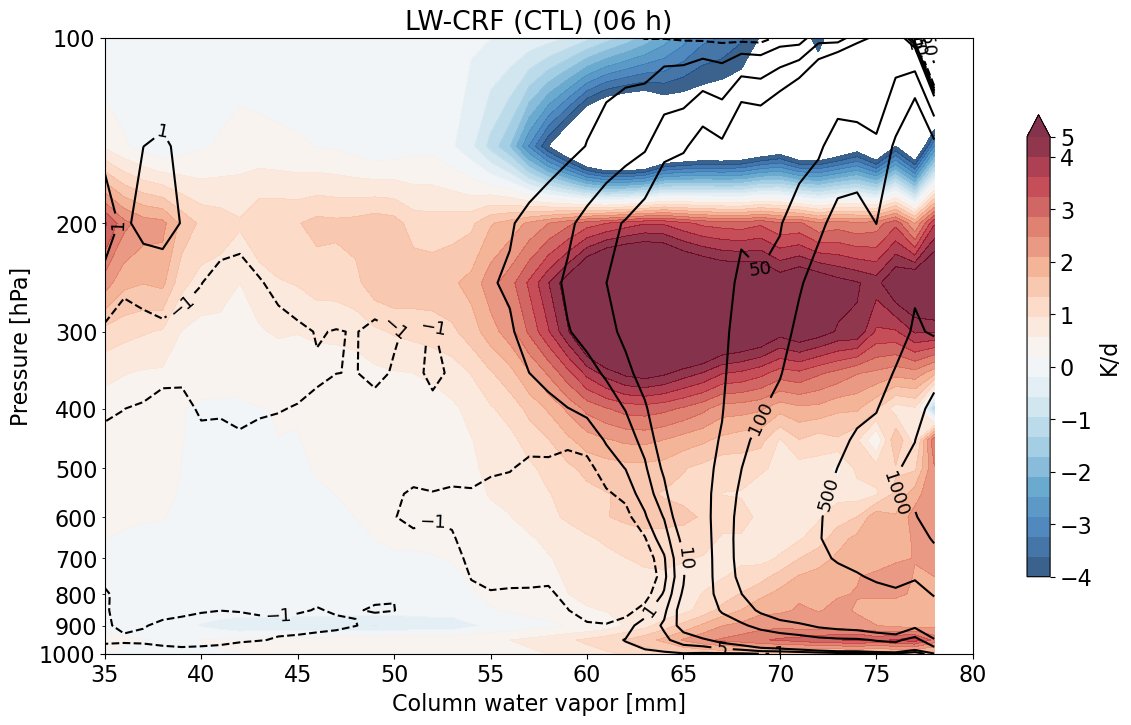

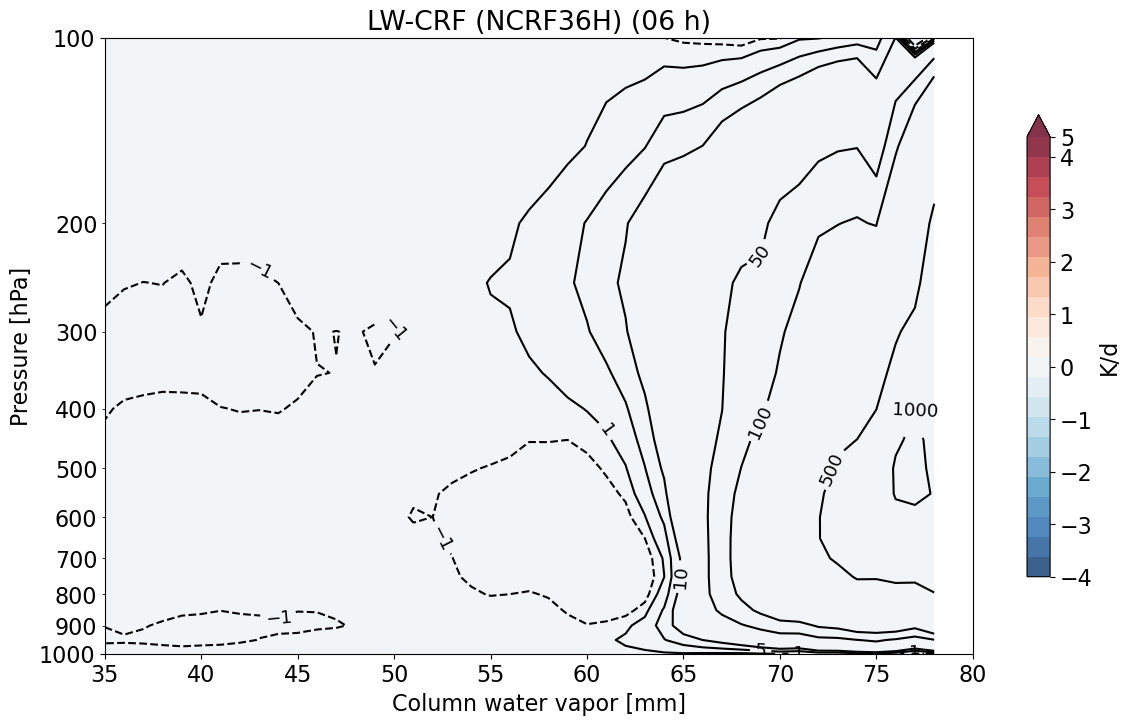

In [13]:
# Loop over sensitivity tests
for ktest in range(ntest):

    test_str=tests[ktest].upper()
    if istrat > -1:
        fig_title = title+' ('+strattag+') ('+test_str.upper()+') ('+hr_tag+' h)'
    else:
        fig_title = title+' ('+test_str.upper()+') ('+hr_tag+' h)'
    
    # create figure
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111)

    ax.set_title(fig_title)
    ax.set_ylabel('Pressure [hPa]')

    pltvar=var_binned[ktest,:,:]
    cpltvar=cvar_binned[ktest,:,:]

    # fill contour
    nlevs=21
    inc=(cmax-cmin)/nlevs
    clevs = np.arange(cmin, cmax+inc, inc)
    im = ax.contourf(bins[0:nbins-1], pres, np.transpose(pltvar), clevs, cmap=cmap, alpha=0.8, \
                    extend='max', zorder=2)

    cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
    cbar.ax.set_ylabel(units_var1)
    
    plt.ylim(100,np.max(pres))
    ax.invert_yaxis()
    ax.set_yscale('log')
    ax.set_xscale(log_x)
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

    ax.set_xlabel(xlabel)
    plt.xlim(np.min(bins), np.max(bins))

    # ax2=ax.twinx()
    # im = ax.plot(bins[0:nbins-1], binvar_s_mn)

    # line contour
    # clevs = np.arange(lcmin, lcmax, lcint)
    # clevs = [0.1,0.5,1,2,5,10,50,100,500,1000,2000,3000]
    clevs = [1,5,10,50,100,500,1000,2000,3000]
    clevs = np.concatenate((-1*np.flip(clevs),clevs))
    # cpltvar=np.gradient(binvar_c_mn,10000,axis=1,edge_order=2)*-1e5
    im = ax.contour(bins[0:nbins-1], pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
    ax.clabel(im, im.levels, inline=True, fontsize=13)

    figtag2 = figtag+'_'+ivar_select+fig_extra
    plt.savefig(figdir+'binnedcross_'+figtag2+'_'+tests[ktest].lower()+'_ens'+enstag+'m_'+hr_tag+'.png',dpi=200, facecolor='white', \
                bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()

### Difference between sensitivity tests

In [14]:
# # Difference between sensitivity tests

# if istrat == -1:
#     fig_title = title+' ('+tests[0].upper()+'-'+tests[1].upper()+') ('+hr_tag+' h)'
# else:
#     fig_title = title+': '+strattag+' ('+tests[0].upper()+'-'+tests[1].upper()+') ('+hr_tag+' h)'

# # create figure
# fig = plt.figure(figsize=(14,8))
# ax = fig.add_subplot(111)

# ax.set_title(fig_title)
# ax.set_ylabel('Pressure [hPa]')

# pltvar =  var_binned[0,:,:] - var_binned[1,:,:]
# cpltvar = cvar_binned[0,:,:]  - cvar_binned[1,:,:]

# # fill contour
# nlevs=21
# inc=(cmax_diff-cmin_diff)/nlevs
# clevs = np.arange(cmin_diff, cmax_diff+inc, inc)
# im = ax.contourf(bins[0:nbins-1], pres, np.transpose(pltvar), clevs, cmap='RdBu_r', alpha=0.8, \
#                 extend='max', zorder=2)

# cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
# cbar.ax.set_ylabel(units_var1)

# plt.ylim(100,np.max(pres))
# ax.invert_yaxis()
# ax.set_yscale('log')
# ax.set_xscale(log_x)
# ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

# ax.set_xlabel(xlabel)
# plt.xlim(np.min(bins), np.max(bins))

# # ax2=ax.twinx()
# # im = ax.plot(bins[0:nbins-1], binvar_s_mn)

# # line contour
# # clevs = np.arange(lcmin, lcmax, lcint)
# # clevs = [0.1,0.5,1,2,5,10,50,100,500,1000,2000,3000]
# clevs = [0.2,0.5,1,2]
# clevs = [.5,1,5,10,50]
# clevs = np.concatenate((-1*np.flip(clevs),clevs))
# # cpltvar=np.gradient(binvar_c_mn,10000,axis=1,edge_order=2)*-1e5
# im = ax.contour(bins[0:nbins-1], pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
# ax.clabel(im, im.levels, inline=True, fontsize=13)

# figtag2 = figtag+'_'+ivar_select+fig_extra
# plt.savefig(figdir+'binnedcross_'+figtag2+'_diff_ens'+enstag+'m_'+hr_tag+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)
# plt.show()
# plt.close()

### Conv/Strat Area

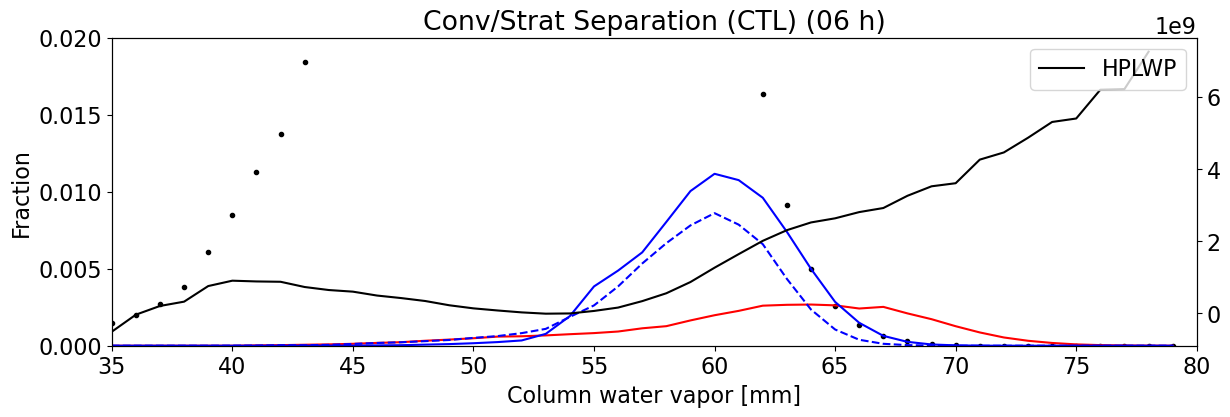

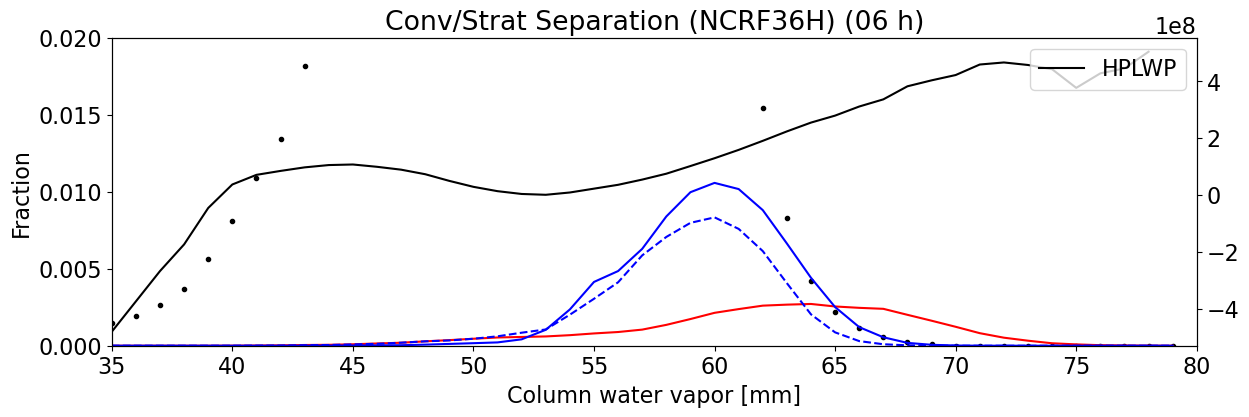

In [15]:
# Loop over sensitivity tests
for ktest in range(ntest):

    test_str=tests[ktest]
    fig_title = 'Conv/Strat Separation ('+test_str.upper()+') ('+hr_tag+' h)'
    
    # create figure
    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot(111)

    ax.set_title(fig_title)
    ax.set_xlabel(xlabel)
    ax.set_xscale(log_x)

    # Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain

    # As fraction of all-points-total
    ax.set_ylabel('Fraction')
    total=np.sum(strat_binned[ktest,:,:])

    plt.plot(bins[0:nbins-1], strat_binned[ktest,:,0]/total \
            , ".k", label="Non-raining")
    plt.plot(bins[0:nbins-1], strat_binned[ktest,:,1]/total \
            , "-r", label="Conv")
    plt.plot(bins[0:nbins-1], strat_binned[ktest,:,2]/total \
            , "-b", label="Strat")
    plt.plot(bins[0:nbins-1], strat_binned[ktest,:,3]/total \
            , "--b", label="Other")

    plt.xlim(np.min(bins), np.max(bins))
    plt.ylim(0, 0.020)

    ax.twinx()
    plt.plot(bins[0:nbins-1], mselw_binned[ktest,:], "-k", label="HPLWP")

    plt.legend(loc="upper right")

    plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'_'+hr_tag+'.png',dpi=200, facecolor='white', \
                bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()

### Difference between sensitivity tests

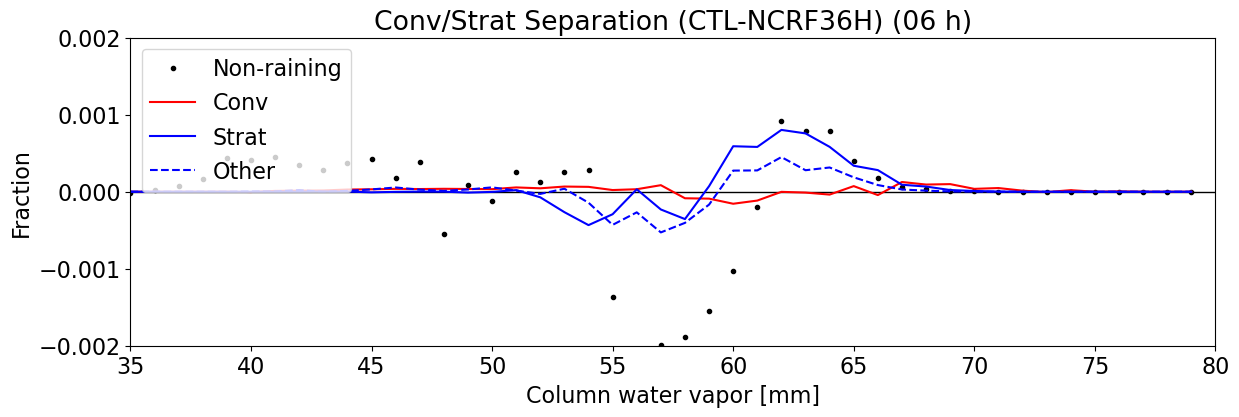

In [16]:
# Loop over sensitivity tests

fig_title = 'Conv/Strat Separation ('+tests[0].upper()+'-'+tests[1].upper()+') ('+hr_tag+' h)'

# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

ax.set_title(fig_title)
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

# Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain

strat_var = strat_binned[0,:,:] - strat_binned[1,:,:]

# As fraction of all-points-total
ax.set_ylabel('Fraction')
total=np.sum(strat_binned[0,:,:])

plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth=1)

plt.plot(bins[0:nbins-1], strat_var[:,0]/total \
        , ".k", label="Non-raining")
plt.plot(bins[0:nbins-1], strat_var[:,1]/total \
        , "-r", label="Conv")
plt.plot(bins[0:nbins-1], strat_var[:,2]/total \
        , "-b", label="Strat")
plt.plot(bins[0:nbins-1], strat_var[:,3]/total \
        , "--b", label="Other")

plt.xlim(np.min(bins), np.max(bins))
plt.ylim(-0.002, 0.002)

plt.legend(loc="upper left")

plt.savefig(figdir+'binnedcross_convstrat_diff_ens'+enstag+'m_'+ivar_select+'_'+hr_tag+'.png',dpi=200, facecolor='white', \
            bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

### LW ACRE by classification

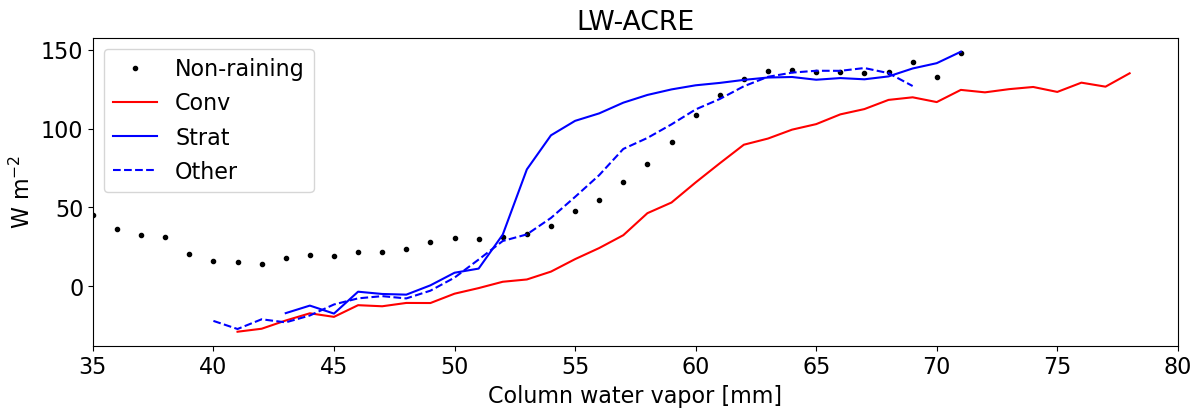

In [17]:
# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

vartag_2d='LW-ACRE'
figtag='lwacrestrat'
ytag='W m$^{-2}$'
# vartag_2d="$h'LW'$"
# figtag='hplwpstrat'
# ytag=' '

# ax.set_title('LW-ACRE * Rain Fraction')
ax.set_title(vartag_2d)
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

ax.set_ylabel(ytag)

for ktest in range(0,1):
        # As fraction of all-rain-total
        # total=np.sum(strat_binned[:,(1,2,3)])
        # plt.plot(bins[0:nbins-1], var2d_binned_mn*strat_binned[:,0]/total \
        #          , ".k", label="Non-raining")
        # plt.plot(bins[0:nbins-1], binvar_acre_mn*strat_binned[:,1]/total \
        #          , "-r", label="Conv")
        # plt.plot(bins[0:nbins-1], binvar_acre_mn*strat_binned[:,2]/total \
        #          , "-b", label="Strat")
        # plt.plot(bins[0:nbins-1], binvar_acre_mn*strat_binned[:,3]/total \
        #          , "--b", label="Other")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,0] \
                , ".k", label="Non-raining")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,1] \
                , "-r", label="Conv")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,2] \
                , "-b", label="Strat")
        plt.plot(bins[0:nbins-1], lwacre_strat[ktest,:,3] \
                , "--b", label="Other")

        plt.xlim(np.min(bins), np.max(bins))
        # plt.ylim(0, 10)

        plt.legend(loc="upper left")

        # plt.savefig(figdir+'lwacrescaled_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
        plt.savefig(figdir+figtag+'_comp_ens'+enstag+'m_'+ivar_select+'.png',dpi=200, facecolor='white', \
                    bbox_inches='tight', pad_inches=0.2)
        plt.show()

### MSE'LW' by classification

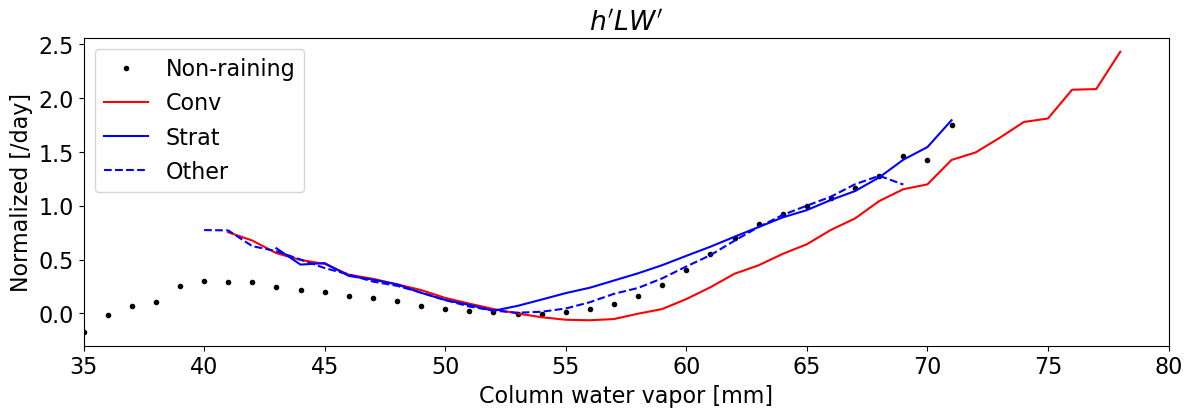

In [18]:
# create figure
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)

mse_plot = mselw_strat / msevar[:,np.newaxis,np.newaxis]
mse_plot *= 3600*24

vartag_2d="$h'LW'$"
figtag='hplwpstrat'
ytag='Normalized [/day]'

# ax.set_title('LW-ACRE * Rain Fraction')
ax.set_title(vartag_2d)
ax.set_xlabel(xlabel)
ax.set_xscale(log_x)

ax.set_ylabel(ytag)

for ktest in range(0,1):
        plt.plot(bins[0:nbins-1], mse_plot[ktest,:,0] \
                , ".k", label="Non-raining")
        plt.plot(bins[0:nbins-1], mse_plot[ktest,:,1] \
                , "-r", label="Conv")
        plt.plot(bins[0:nbins-1], mse_plot[ktest,:,2] \
                , "-b", label="Strat")
        plt.plot(bins[0:nbins-1], mse_plot[ktest,:,3] \
                , "--b", label="Other")

        plt.xlim(np.min(bins), np.max(bins))
        # plt.ylim(0, 10)

        plt.legend(loc="upper left")

        # plt.savefig(figdir+'lwacrescaled_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
        plt.savefig(figdir+figtag+'_comp_ens'+enstag+'m_'+ivar_select+'.png',dpi=200, facecolor='white', \
                        bbox_inches='tight', pad_inches=0.2)
        plt.show()

### VMF

In [19]:
# # create figure
# fig = plt.figure(figsize=(14,4))
# ax = fig.add_subplot(111)

# ax.set_title('Vertical mass flux')
# ax.set_xlabel(xlabel)
# ax.set_xscale(log_x)

# # ax.set_ylabel('kg/m/s')
# # plt.plot(bins[0:nbins-1], binvar_vmfl_mn, "-k", label="Lower")
# # plt.plot(bins[0:nbins-1], binvar_vmfh_mn, "--k", label="Upper")
# ax.set_ylabel('%')
# plt.plot(bins[0:nbins-1], binvar_vmfth_mn, "-k", label="TH index")

# plt.xlim(np.min(bins), np.max(bins))
# # plt.ylim(0, 0.2)
# # ax.set_yscale('log')

# plt.legend(loc="upper left")


# plt.show()
# # plt.savefig(figdir+'convstrat_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
# #             bbox_inches='tight', pad_inches=0.2)

### Test of vertical mode decomposition

In [20]:
# # A specific, known sinusoidal function
# nlevs=100
# nharmonic = 5
# scale = [3.,9,15,25,50,100]
# # scale = np.ones(nharmonic)
# zind=np.arange(0,1,1./nlevs)
# fx = np.zeros(nlevs)
# for nk in range(nharmonic):
#     fx += np.sin(2*np.pi*(nk+1)*zind) * scale[nk]
#     # print(np.sin(2*np.pi*(nk+1)*zind))


# an = np.zeros(nharmonic)
# bn = np.zeros(nharmonic)
# for nk in range(nharmonic):
#     # print("k = ",nk+1)
#     kx = 2*np.pi * (nk+1) * zind
#     # print("kx = ",kx)
#     an[nk] = (2./nlevs) * np.sum( fx * np.cos(kx) )
#     bn[nk] = (2./nlevs) * np.sum( fx * np.sin(kx) )

# # # power=np.sqrt(an**2 + bn**2)
# power=an + bn
# # power=np.abs(power)
# # print(an)
# print(power)

# # create figure
# fig = plt.figure(figsize=(5,4))
# ax = fig.add_subplot(111)
# ax.set_title('Sine function')
# ax.set_ylabel('z/H')

# plt.plot(fx, zind)

# plt.show()

### LW ACRE

In [21]:
# # create figure
# fig = plt.figure(figsize=(14,4))
# ax = fig.add_subplot(111)

# ax.set_title('LW-ACRE')
# ax.set_xlabel(xlabel)
# ax.set_xscale(log_x)

# pltvar=binvar_acre_mn

# ax.set_ylabel('ACRE [W/m**2]')
# plt.plot(bins[0:nbins-1], pltvar)

# # plt.ylim(0, 0.2)
# plt.xlim(np.min(bins), np.max(bins))

# # plt.legend(loc="upper left")

# plt.show()
# # plt.savefig(figdir+'lwacre_comp_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
# #             bbox_inches='tight', pad_inches=0.2)